## MLE computation

compute the MLE to check quality of estimates and code functionality.

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

In [35]:
using DataFrames, Optim, Plots, ForwardDiff, LinearAlgebra, Distributions

#### tools that need to be integrated to src

In [50]:
function correlation_covariance_matrix(eval_pt::Vector{Float64}, prm_keys::Vector, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0)
    fim = - ForwardDiff.hessian(x -> Src.compute_ll(x, prm_keys, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs), eval_pt)
    cov = inv(fim)
    cor = [cov[i,j] / sqrt(cov[i,i]*cov[j,j]) for i in range(1, size(cov,1)), j in range(1, size(cov,2))]
    return cor, cov
end

function plot_mult_restart_mles(inits::Matrix, mles::Matrix, ind_best::Int64; compare::Bool=true, N::Int64=20)
    plot(mles[:,1], label="MLEs", title="Multiple restart MLE of a",color="#165DB1",linewidth=2, ylabel="parameter value", xlabel="restart index")
    hline!([hprm.a], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
    scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color="#165DB1", label="")

    if compare
        plot!(inits[:,1], label="inits", color="#9ABCE4",linewidth=1)
        scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color="#9ABCE4", label="")
    end
    scatter!([ind_best], [mles[ind_best, 1]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="best estimate")
end

function plot_mult_restart_losses(inits_loss::Vector, losses::Vector, ind_best::Int64; compare::Bool=false, N::Int64=20)
    plot(losses, label="MLEs", color="#165DB1",linewidth=2, title="Loss evolution of multiple restart MLE", ylabel = "loss value", xlabel="restart index")
    scatter!(1:N, losses, markershape=:square, markersize=2, color="#165DB1", label="")

    if compare
        plot!(inits_loss, label="init", color="#9ABCE4",linewidth=1)
        scatter!(1:N, inits_loss, markershape=:square, markersize=2, color="#9ABCE4", label="")
    end

    scatter!([ind_best], [losses[ind_best]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="lowest")
end

"""
    plot_gaussian(mle::Vector, cov::Matrix)

Visualizes a bivariate Gaussian distribution given its mean (MLE) and covariance.

# Arguments
- `mle::Vector`: A 2-element vector `[a_mean, m_mean]` representing the mean (maximum likelihood estimate) of the distribution.
- `cov::Matrix`: A 2×2 covariance matrix of the Gaussian.

# Returns
- `heatmap_plot`: A 2D heatmap of the probability density function over a grid centered around the MLE, with the MLE marked.
- `surface_plot`: A combined 3D surface plot from two different viewpoints, also showing the MLE as a point.
"""
function plot_gaussian(mle::Vector, cov::Matrix)
    # define distribution
    posterior = MvNormal(mle, cov)

    # plotting ranges
    d = max(3*sqrt(cov[1,1]),3*sqrt(cov[2,2])) # make axes comparable
    a = range(mle[1]-d, mle[1]+d, length=500)
    m = range(mle[2]-d, mle[2]+d, length=500)
    pdf_evals = [pdf(posterior, [ai, mi]) for mi in m, ai in a]

    # create heatmap
    heatmap_plot = heatmap(a,m,pdf_evals, xlabel="a", ylabel="m")
    scatter!([mle[1]], [mle[2]], markersize=3, color=:"#0065bd", label="MLE")

    # create 3D plots from different viewpoints
    v1 = plot(a, m, pdf_evals, st=:surface, xlabel="a", ylabel="m", colorbar=false)
    scatter!([mle[1]], [mle[2]], [0], markersize=5, color=:"#0065bd", label="MLE")
    v2 = plot(m, a, pdf_evals', st=:surface, xlabel="m", ylabel="a", colorbar=false)
    scatter!([mle[2]], [mle[1]], [0], markersize=5, color=:"#0065bd", label="")
    surface_plot = plot(v1,v2, layout=(1,2), size=(800,400))

    return heatmap_plot, surface_plot
end

plot_gaussian

### create simulated data obs

In [4]:
# define which parameters should be inferred and choose test point
a_true = 1.5
m_true = 0.45

prm_keys = [:a, :m]
exp_point = [a_true, m_true];

In [5]:
# further settings
t_fixed = true

true

In [6]:
# generate observation data
noise = 0.01
M = 100
hprm = Src.Hyperprm(1.0, 1.0, a_true, m_true, M, noise)

Main.Src.Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.01)

In [46]:
function assess_practical_identifiability(point::Vector, prm_keys::Vector, hprm::Src.Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0, N::Int64=20)
    
    # create data observations and include noise
    sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
    Src.randomize_data!(sol_true, hprm.noise); # make data noisy

    # compute MLE via multiple restart optimizations
    inits, inits_loss, mles, losses, best_loss_ind, converged = Src.mult_restart_mle(N, prm_keys, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
    mle = mles[best_loss_ind,:]
    plot_mles = plot_mult_restart_mles(inits, mles, best_loss_ind, N=N)
    plot_losses = plot_mult_restart_losses(inits_loss, losses,best_loss_ind, N=N)

    # compute covariance/ correlation Matrix
    cor, cov = correlation_covariance_matrix(mle, prm_keys, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
    display(cor)
    display(cov)

    # plot MvNormals (Fisher Approximation)
    #gaussian_heatmap, gaussian_surface = plot_gaussian(mle, cov)

    return return (
        mle = mle,
        plot_mles = plot_mles,
        plot_losses = plot_losses,
        correlation = cor,
        covariance = cov,
        #gaussian_heatmap = gaussian_heatmap,
        #gaussian_surface = gaussian_surface,
    )
end

assess_practical_identifiability (generic function with 1 method)

In [47]:
result = assess_practical_identifiability(exp_point, prm_keys, hprm, t_fixed=t_fixed)

2×2 Matrix{Float64}:
 1.0       0.997644
 0.997644  1.0

2×2 Matrix{Float64}:
 0.00367282  0.00111782
 0.00111782  0.000341817

(mle = [1.5048709656939594, 0.4515118744554616], plot_mles = Plot{Plots.GRBackend() n=6}, plot_losses = Plot{Plots.GRBackend() n=3}, correlation = [1.0 0.9976435359619704; 0.9976435359619689 1.0], covariance = [0.0036728211381828156 0.001117820577697498; 0.0011178205776974962 0.0003418169818484481])

In [48]:
result.mle

2-element Vector{Float64}:
 1.5048709656939594
 0.4515118744554616

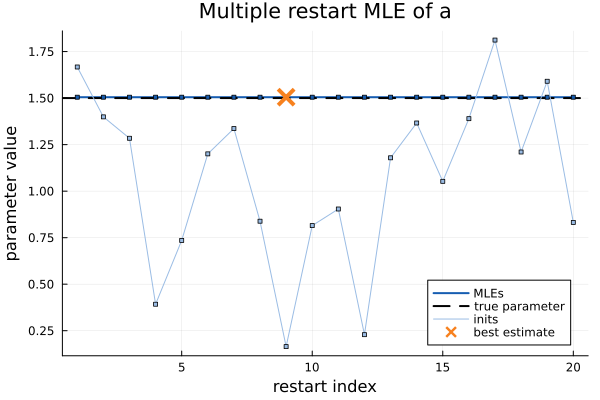

In [51]:
result.plot_mles

## old stuff

### experiment for single sample

In [6]:
# compute MLE
mle, success = Src.compute_mle(prm_keys, hprm, sol_true; t_fixed=true, t_end=100.0) # compute MLE
print("mle = $mle")

mle = [1.6296492246442056, 0.49100479573826755]

In [7]:
# compute Fi evaluated at MLE and at true prm point
# compare both and see that Fi differs. Note that fi_mle must not necessarily be higher than fi_true

fi_mle = Src.compute_fi(mle, prm_keys, hprm, sol_true; t_fixed=true, t_end=100.0)
fi_true = Src.compute_fi([a_true,m_true], prm_keys, hprm, sol_true; t_fixed=true, t_end=100.0)

print("fi_mle, fi_true = $fi_mle, $fi_true")

fi_mle, fi_true = 60506.994723406075, 72320.48506515229

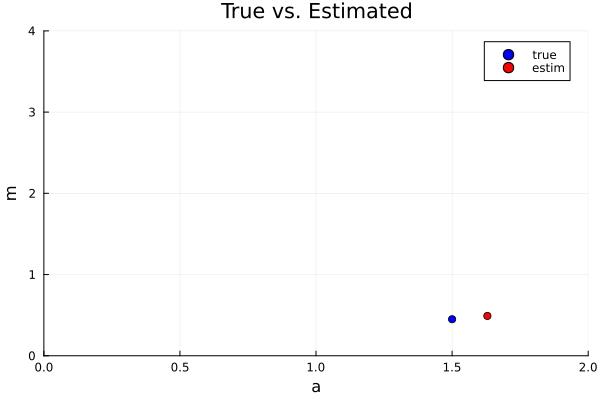

In [8]:
# plot true prm vs MLE
scatter([a_true], [m_true], label = "true", color = :blue,xlabel = "a", ylabel = "m", xlims = (0, 2), ylims = (0, 4),legend = :topright,title = "True vs. Estimated")
scatter!([mle[1]], [mle[2]], label = "estim", color = :red)

I checked the corresponding log-likelihood plots for different points and noise levels and the MLEs visually fit the maxima of the respective log-likelihood functions.

### multiple restart opim

In [9]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = Src.mult_restart_mle(N, prm_keys, hprm, sol_true, t_fixed=true, t_end=100.0); # Q: right now for a, n0 prm 

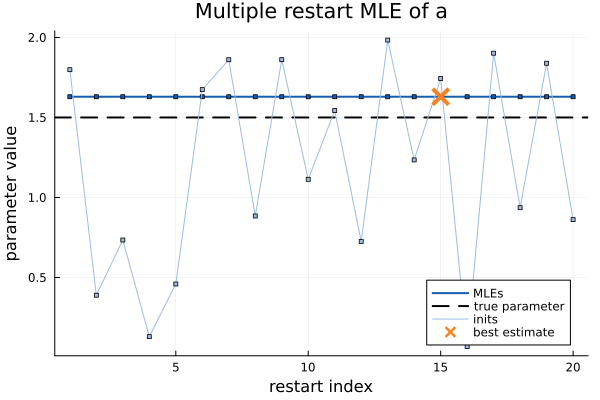

In [59]:
# plot inits vs. mles
plot_mult_restart_mles(inits, mles, best_loss_ind)

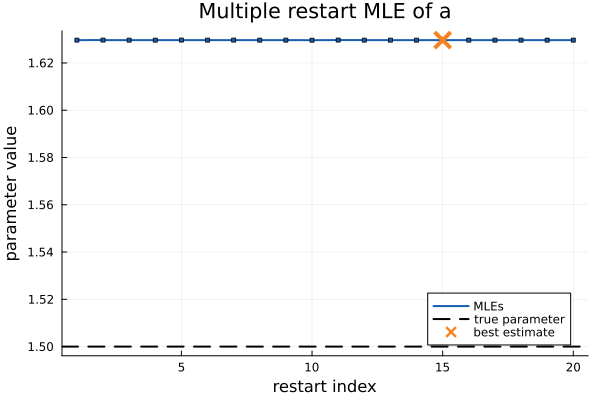

In [60]:
plot_mult_restart_mles(inits, mles, best_loss_ind, compare=false)

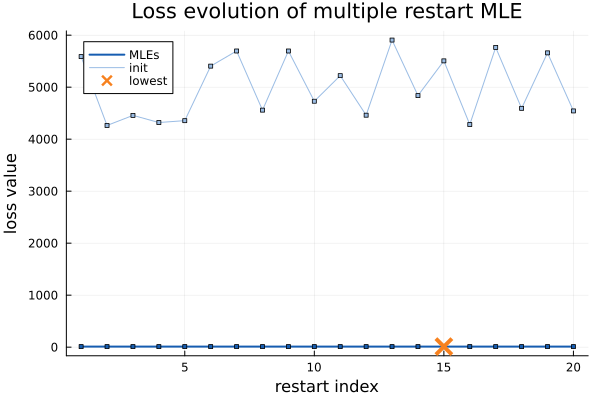

In [61]:
# plot losses
plot_mult_restart_losses(inits_loss, losses, best_loss_ind)

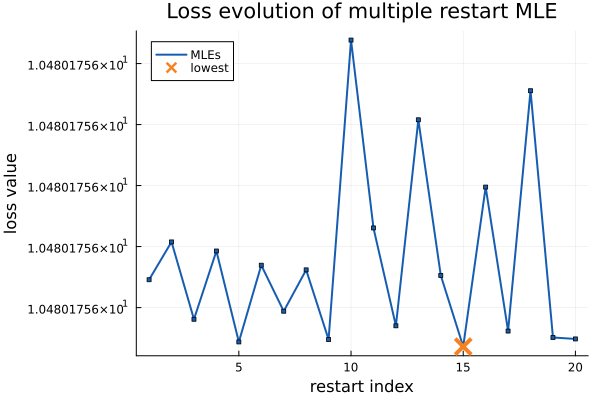

In [62]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

- Left: seems pi
- Middle: seems pi
- Right: seems pi

I tried out different regimes of a.
Identifiability differs depending on whether a is left or right to the bifurcation point. 
If a right of bifurcation point, there appears to be another local minimum -> not practically identifiable! ????? cannot reproduce these results (oh, maybe with noise = 1.0)

TODO:
- plot profile likelihood
- check loss: why are the values so high? and so different -> there seems to be a local minimum far away
- why are values positive? -> makes sense: ll is negative, thus nll is positive
- why is loss so high? normal? -> sollte schon passen (zumindest ist loss ~0, wenn noise=0.0)

### analyze correlation matrix

In [15]:
eval_pt = mles[best_loss_ind,:] # Q: should be MLE or what?

2-element Vector{Float64}:
 1.4293661025353415
 0.4288126441027291

inverse of the FIM is approximation of the covariance matrix -> rescale to get parameter correlations (source: tools paper)

In [ ]:

correlation_matrix(eval_pt, prm_keys, hprm, sol_true, t_fixed=true, t_end=100.0)

2×2 Matrix{Float64}:
  1.0        -0.0963278
 -0.0963278   1.0

- Left: negative correlation, -0.21
- Middle: neg.corr., -0.07
- Right: neg. corr., -0.09